In [10]:
# Importing libraries #
import pandas as pd
import numpy as np
import numpy
import sklearn
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels
import math
import matplotlib as mpl
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [11]:
filepath = 'mock_dataset'
site_id = 'Site Number'
utilization = '% Utilization'
date = 'Date'
na_values = ['.......']

# Read in mock historical cellular dataset 
csv = pd.read_csv(filepath, usecols=[site_id, utilization, date], dtype={site_id : int , utilization : float}, index_col=date, na_values = na_values, )
# Fill missing values of column with the mean
csv.loc[:, utilization] = csv.loc[:, utilization].fillna(csv.loc[:, utilization].mean())

In [12]:
# Set index type as DataTime for later processing
csv.index = pd.to_datetime(csv.index)

In [13]:
# Print first 10 lines of mock dataset
csv.head(10)

,Site Number,% Utilization
Date,,
2016-09-18,606903,39.278896
2016-09-25,606903,43.337650
2016-10-02,606903,45.864549
2016-10-09,606903,56.820965
2016-10-16,606903,50.551196
2016-10-23,606903,56.820965
2016-10-30,606903,53.788377
2016-11-06,606903,53.788377
2016-11-13,606903,53.788377


In [14]:
# This code creates the template for the report.csv file
## that will be generated later. report.csv contains
## the historical data for each cell site, along the 52 
## weeks of % Utilization predictions, along with the 
## confidence of each prediction.

# Global Variables #
cell_sites = csv.groupby(site_id)
num_cell_sites = len(cell_sites)
minimume_size = 104
num_predictions = 52
counter = 0
weeks = []
week = "week_"
accuracy = "percent_error"

columns = []
results_dict = {}
results_dict[site_id] = []

# Create the week columns 
for i in range(1,num_predictions+1):
    col_name = week + str(i)
    # Creating dictionary that will be printed to csv file
    results_dict[col_name] = []
    weeks.append(col_name)
results_dict[accuracy] = []

# Name the columns for ouput file
columns.append(site_id)
columns.extend(weeks)
columns.append(accuracy)

model_results_csv = pd.DataFrame(columns=columns)

In [15]:
# Create a differenced series (Y(n) = X(n) - X(n-1))
## Y(n) represents the week to week change in utilization.
## This is done in order to make the tiem series data 
## 'Stationary' so it can be used in the ARIMA model
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval] ## NEW
        diff.append(value)
    return numpy.array(diff)

# Used as the inverse of the difference function
def inverse_difference(history, yhat, interval=1):
    invers_result = yhat + history[-interval] ## NEW
    return invers_result

In [16]:
# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


# Evaluate combinations of p, d and q values for an ARIMA model
## useful for automating the processes of (p,d,q) selection
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    # Uncomment to print the current (p,d,q) values
                    # print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    # Uncomment to print values of (p,d,q) for the most accurate model
    # print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

In [24]:
def save_figure_as_png(site_identifier):
    plt.savefig('Site_' + str(site_identifier) + '.png')
    
def create_plot(history, historic_data, site_identifier):
    ## Plot visual customization
    plt.figure(figsize=(14,8))
    plt.style.use('dark_background')
    plt.title(site_identifier)
    plt.ylabel('% utilization')
    plt.xlabel('week number')
    plt.grid('off')
    plt.ylim(0,100)
    plt.plot(history, color='cyan', label='future prediction')
    plt.plot(historic_data.loc[:, utilization].values.tolist(), color='w')
    plt.plot(np.exp(X), color='orange',label='historical data')
    plt.legend()
    save_figure_as_png(site_identifier)
    plt.show()

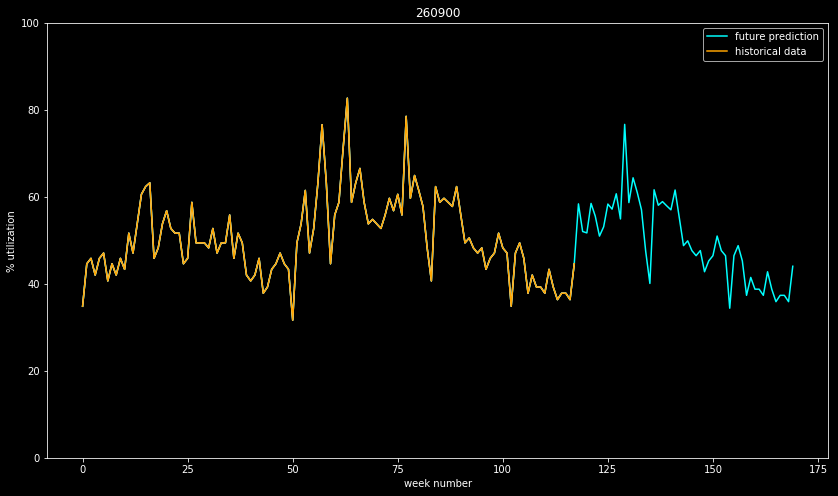

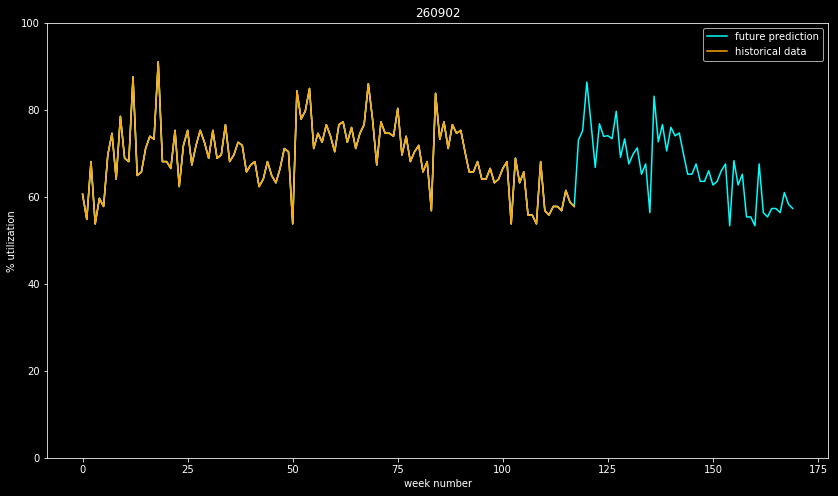

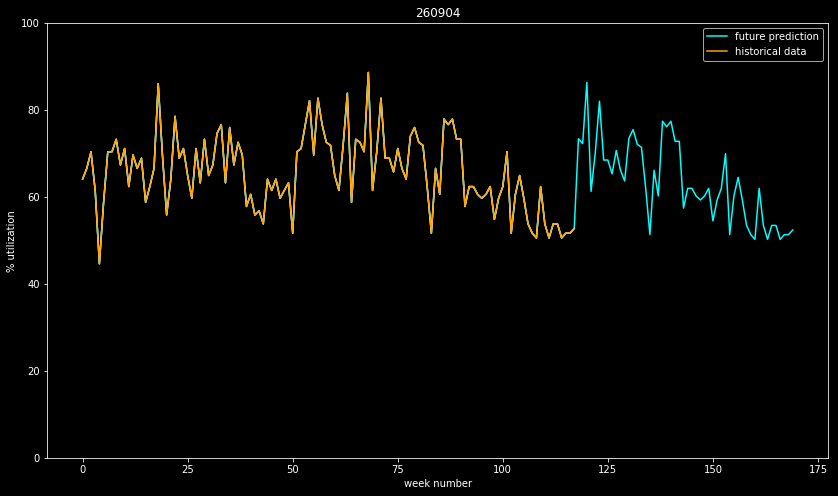

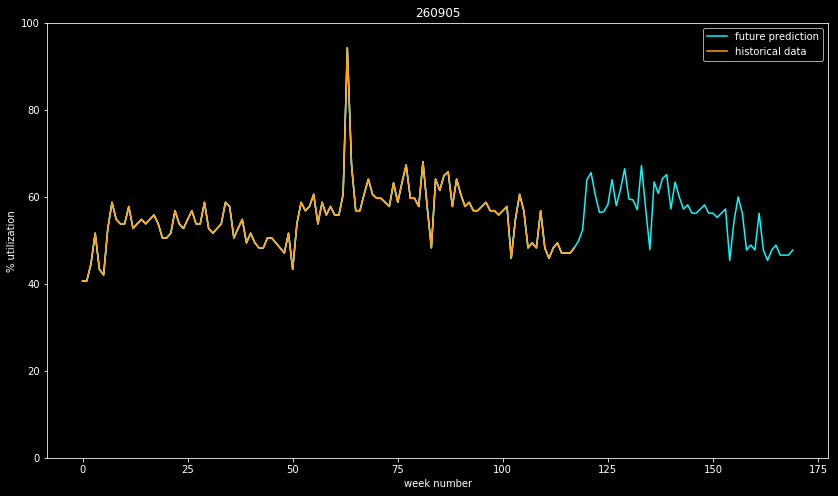

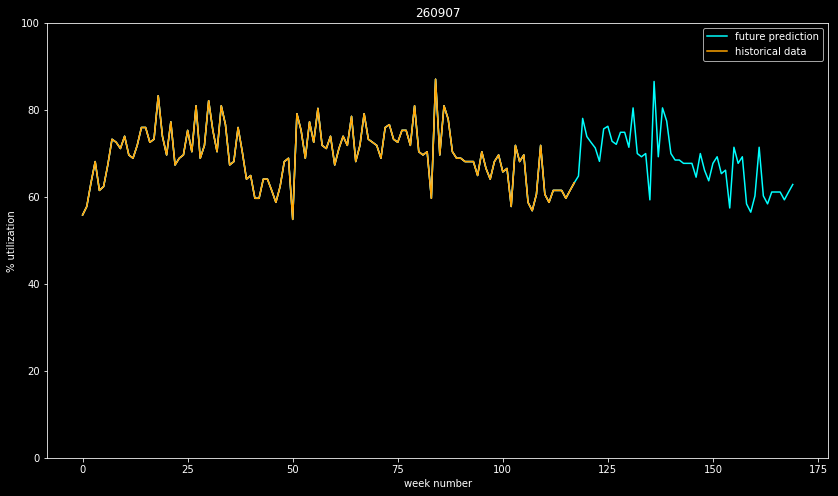

In [25]:
# Global Variables #
## Setting values of p,d,q that
## evaluate_models() function will 
## iterate through when searching for
## most optimum ARIMA model
p_values = [0,1,2,4]
d_values = [0, 1]
q_values = [0, 1]
warnings.filterwarnings("ignore")
count = 0

# Minimum number of historical datapoints
## a cellular site requires in order to have 
## the ARIMA model applied
minimume_size = 104


# Filter sites
## If a site has fewer historical datapoints than
## the minimum number set above, that site is ignored
## else, apply the ARIMA model to that cellular site
for site_identifier, historic_data in cell_sites:
    new_row = [site_identifier]
    num_data_points = historic_data.shape[0]
    result = 0
    results_dict[site_id].append(site_identifier)
    
    if num_data_points < minimume_size:
        for i in range(1, num_predictions+1):
            column_name = week + str(i)
            # Fill column names with zero
            results_dict[column_name].append(0)
        # Fill accuracy column with na
        results_dict[accuracy].append('na')
    else:
        ## Apply log to each datapoint in order to make the data 'stationary'
        timeseries = historic_data.loc[:, utilization].apply(lambda x: math.log(x))
        X = timeseries.values
         
        days_in_year = 52
        differenced = difference(X, days_in_year)
        differenced_2 = difference(differenced)  # Second order difference

        order, error = evaluate_models(differenced, p_values, d_values, q_values)
        
        # fit the model
        model = ARIMA(differenced, order=order)
        model_fit = model.fit(disp=0)
        
        # multi-step out-of-sample forecast
        start_index = len(differenced)
        end_index = start_index + (num_predictions-1)
        forecast = model_fit.predict(start=start_index, end=end_index)  

        # invert the differenced forecast to something usable
        history = [x for x in X]
        predictions = []
        day = 1
        for yhat in forecast:
            inverted = inverse_difference(history, yhat, days_in_year)
            history.append(inverted)
            
        ## Find inverse-log to get back to original scale
        history = np.exp(history)
        
        ## Logic for printing daily predictions to csv file
        for i in range(1, num_predictions+1):
            column_name = week + str(i)
            # Fill column names with zero
            results_dict[column_name].append(history[i-1])
            
        results_dict[accuracy].append(error)
        rng = pd.date_range(timeseries.index[-1], periods=1 + num_predictions, freq='W')
        create_plot(history, historic_data, site_identifier)
        
    # Stop this loop early
    ## The real application produces
    ## 5,000+ output images such as 
    ## these shown below
    count = count + 1
    if(count > 4):
        break

In [19]:
# Conver results_dict into a dataframe, set the index to 'site number', drop the 'site number column'
results_df = pd.DataFrame(results_dict)
site_id_column = results_df.loc[:, site_id]
results_df = results_df.set_index(site_id_column)
results_df = results_df.drop(site_id, axis=1)
results_df.to_csv('Report.csv')